In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from salishsea_tools import geo_tools, viz_tools, evaltools as et
import gsw
import netCDF4 as nc
import datetime as dt
import cmocean
import pickle
import os
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
obslat=50.117
obslon=-125.223

In [3]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])
    e3t_0=np.copy(mesh.variables['e3t_0'][0,:,:,:])
    print(mesh.variables.keys())

dict_keys(['nav_lon', 'nav_lat', 'nav_lev', 'time_counter', 'tmask', 'umask', 'vmask', 'fmask', 'tmaskutil', 'umaskutil', 'vmaskutil', 'fmaskutil', 'glamt', 'glamu', 'glamv', 'glamf', 'gphit', 'gphiu', 'gphiv', 'gphif', 'e1t', 'e1u', 'e1v', 'e1f', 'e2t', 'e2u', 'e2v', 'e2f', 'ff', 'mbathy', 'misf', 'isfdraft', 'e3t_0', 'e3u_0', 'e3v_0', 'e3w_0', 'gdept_0', 'gdepu', 'gdepv', 'gdepw_0', 'gdept_1d', 'gdepw_1d', 'e3t_1d', 'e3w_1d'])


depth is 15 grid points at site or roughly 15.1 m


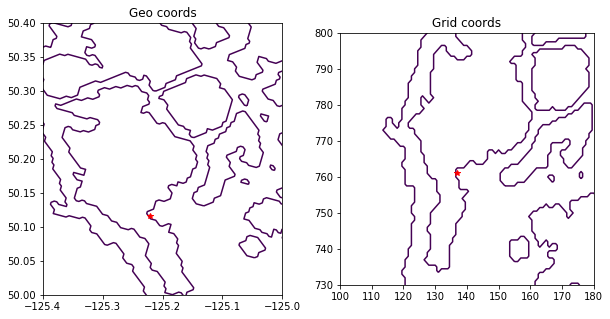

In [4]:
j,i=geo_tools.find_closest_model_point(obslon,obslat,navlon,navlat)
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].contour(navlon,navlat,tmask[0,:,:],(0.5,))
ax[0].plot(navlon[j,i],navlat[j,i],'r*')
ax[0].set_xlim(-125.4,-125)
ax[0].set_ylim(50,50.4)
viz_tools.set_aspect(ax[0],coords='map')
ax[0].set_title('Geo coords')
ax[1].contour(tmask[0,:,:],(.5,))
ax[1].plot(i,j,'r*')
ax[1].set_xlim(100,180)
ax[1].set_ylim(730,800)
viz_tools.set_aspect(ax[1],coords='grid')
ax[1].set_title('Grid coords')
ks=np.sum(tmask[:,j,i])
print('depth is {0} grid points at site or roughly {1:3.1f} m'.format(ks,np.sum(e3t_0[:ks,j,i])))

In [5]:
df=pd.read_csv('/ocean/eolson/MEOPAR/obs/IzettCTD/Quadra_Hakai_BoL-data_201906-202004.txt',header=0,skiprows=(1,))

In [6]:
df.head()

,Days,TSG_T,TSG_S,CTD_1_T,CTD_1_S,CTD_1_pr,CTD_2_T,CTD_2_S,CTD_2_pr
0,352.144785,7.259759,21.940098,NaN,NaN,NaN,NaN,NaN,NaN
1,352.148303,7.269010,21.991546,NaN,NaN,NaN,NaN,NaN,NaN
2,352.151799,7.278374,22.002477,NaN,NaN,NaN,NaN,NaN,NaN
3,352.155294,7.269549,21.972746,NaN,NaN,NaN,NaN,NaN,NaN
4,352.158790,7.282700,22.012073,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df['dtUTC']=[dt.datetime(2014,1,1)+dt.timedelta(days=ii) for ii in df['Days']]

In [8]:
df['SA']=[gsw.SA_from_SP(isp,1.4,obslon,obslat) for isp in df['TSG_S']]

In [9]:
df['CT']=[gsw.CT_from_t(isa,ist,1.4) for isa,ist in zip(df['SA'],df['TSG_T'])]

In [10]:
df['Z']=1.4
df['Lat']=obslat
df['Lon']=obslon

In [11]:
df['k']=1
df['i']=i
df['j']=j

In [12]:
df.head()

,Days,TSG_T,TSG_S,CTD_1_T,CTD_1_S,CTD_1_pr,CTD_2_T,CTD_2_S,CTD_2_pr,dtUTC,SA,CT,Z,Lat,Lon,k,i,j
0,352.144785,7.259759,21.940098,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-19 03:28:29.424000,22.046300,7.429968,1.4,50.117,-125.223,1,137,761
1,352.148303,7.269010,21.991546,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-19 03:33:33.379200,22.097997,7.438737,1.4,50.117,-125.223,1,137,761
2,352.151799,7.278374,22.002477,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-19 03:38:35.433600,22.108981,7.448129,1.4,50.117,-125.223,1,137,761
3,352.155294,7.269549,21.972746,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-19 03:43:37.401600,22.079106,7.439522,1.4,50.117,-125.223,1,137,761
4,352.158790,7.282700,22.012073,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-19 03:48:39.456000,22.118623,7.452410,1.4,50.117,-125.223,1,137,761


In [13]:
flen=1
namfmt='nowcast'
filemap={'vosaline':'grid_T','votemper':'grid_T'}
fdict={'grid_T':1,}
PATH='/results2/SalishSea/nowcast-green.201905/'
runID='HC201905'
dstart=dt.datetime(2014,12,19)
dend=dt.datetime(2020,6,20)

In [14]:
len(df)

450137

In [15]:
# remove a day because it is currently missing from model output
df.drop(df.loc[(df.dtUTC>=dt.datetime(2020,6,10))&(df.dtUTC<dt.datetime(2020,6,11))].index,inplace=True)

In [ ]:
data=et.matchData(df,filemap,fdict,dstart,dend,namfmt,PATH,flen,preIndexed=True)

progress: 0.0%
progress: 1.1115063133558598%
progress: 2.2230126267117196%
progress: 3.3345189400675794%
progress: 4.446025253423439%
progress: 5.557531566779299%
progress: 6.669037880135159%
progress: 7.7805441934910196%
progress: 8.892050506846878%
progress: 10.00355682020274%
progress: 11.115063133558598%
progress: 12.226569446914457%
progress: 13.338075760270318%
progress: 14.449582073626177%
progress: 15.561088386982039%
progress: 16.672594700337896%
progress: 17.784101013693757%
progress: 18.895607327049618%
progress: 20.00711364040548%
progress: 21.118619953761335%
progress: 22.230126267117196%
progress: 23.341632580473057%
progress: 24.453138893828914%
progress: 25.56464520718478%
progress: 26.676151520540635%
progress: 27.787657833896496%
progress: 28.899164147252353%
progress: 30.010670460608218%
progress: 31.122176773964078%
progress: 32.23368308731994%
progress: 33.34518940067579%
progress: 34.45669571403165%
progress: 35.568202027387514%
progress: 36.679708340743375%
progr

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
_,_,_,m0=ax[0].hist2d(data['SA'],data['mod_vosaline'],bins=np.linspace(21,28,100),
          cmap=cmocean.cm.amp,cmin=1,cmax=800,vmin=1,vmax=350)
fig.colorbar(m0,ax=ax[0],extend='max')
ax[0].set_aspect(1)
ax[0].set_xlim(21,28)
ax[0].set_ylim(21,28)
ax[0].plot((21,28),(21,28),'k-',lw=.5);
ax[0].set_xlabel('Obs Abs. Sal (g kg$^{-1}$)')
ax[0].set_ylabel('Model Abs. Sal (g kg$^{-1}$)')
_,_,_,m1=ax[1].hist2d(data['CT'],data['mod_votemper'],bins=np.linspace(5.5,10,100),
          cmap=cmocean.cm.amp,cmin=1,cmax=350)
fig.colorbar(m1,ax=ax[1])
ax[1].set_aspect(1)
ax[1].set_xlim(5.5,10)
ax[1].set_ylim(5.5,10)
ax[1].plot((5.5,10),(5.5,10),'k-',lw=.5)
ax[1].set_xlabel('Obs Cons. Temp. (deg C)')
ax[1].set_ylabel('Model Cons. Temp. (deg C)')

In [ ]:
s_sa=et.stats(data['SA'],data['mod_vosaline'])
print('Absolute Salinity\n N: {0}\n bias: {3}\n RMSE: {4}\n Willmott Skill Score: {5}'.format(*s_sa))

In [ ]:
s_ct=et.stats(data['CT'],data['mod_votemper'])
print('Conservative Temperature\n N: {0}\n bias: {3}\n RMSE: {4}\n Willmott Skill Score: {5}'.format(*s_ct))

In [ ]:
df2=data.copy(deep=True)
df2['k']=0

In [ ]:
data2=et.matchData(df2,filemap,fdict,dstart,dend,namfmt,PATH,flen,preIndexed=True)

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
_,_,_,m0=ax[0].hist2d(data2['SA'],data2['mod_vosaline'],bins=np.linspace(21,28,100),
          cmap=cmocean.cm.amp,cmin=1,cmax=800,vmin=1,vmax=350)
fig.colorbar(m0,ax=ax[0],extend='max')
ax[0].set_aspect(1)
ax[0].set_xlim(21,28)
ax[0].set_ylim(21,28)
ax[0].plot((21,28),(21,28),'k-',lw=.5);
ax[0].set_xlabel('Obs Abs. Sal (g kg$^{-1}$)')
ax[0].set_ylabel('Model Abs. Sal (g kg$^{-1}$)')
_,_,_,m1=ax[1].hist2d(data2['CT'],data2['mod_votemper'],bins=np.linspace(5.5,10,100),
          cmap=cmocean.cm.amp,cmin=1,cmax=350)
fig.colorbar(m1,ax=ax[1])
ax[1].set_aspect(1)
ax[1].set_xlim(5.5,10)
ax[1].set_ylim(5.5,10)
ax[1].plot((5.5,10),(5.5,10),'k-',lw=.5)
ax[1].set_xlabel('Obs Cons. Temp. (deg C)')
ax[1].set_ylabel('Model Cons. Temp. (deg C)')

In [ ]:
s_sa=et.stats(data2['SA'],data2['mod_vosaline'])
print('Absolute Salinity\n N: {0}\n bias: {3}\n RMSE: {4}\n Willmott Skill Score: {5}'.format(*s_sa))

In [ ]:
s_ct=et.stats(data2['CT'],data2['mod_votemper'])
print('Conservative Temperature\n N: {0}\n bias: {3}\n RMSE: {4}\n Willmott Skill Score: {5}'.format(*s_ct))

In [ ]:
fig,ax=plt.subplots(2,1,figsize=(16,4))
fig.subplots_adjust(hspace=.3)
ax[0].plot(data['dtUTC'],data['mod_votemper'],'r.',label='model',ms=1)
ax[0].plot(data['dtUTC'],data['CT'],'k.',label='obs',ms=1)
ax[0].legend()
ax[0].set_ylabel('Cons. Temp.\n (deg C)')
ax[1].plot(data['dtUTC'],data['mod_vosaline'],'r.',label='model',ms=1)
ax[1].plot(data['dtUTC'],data['SA'],'k.',label='obs',ms=1)
ax[1].legend()
ax[1].set_ylabel('Abs. Sal.\n (g kg$^{-1}$)')

## SSH Comparisons

In [ ]:
dfssh=pd.read_csv('/ocean/eolson/MEOPAR/obs/IzettCTD/WhaletownTidePred/8038-01-JAN-2015_slev.csv',
                  skiprows=7,delimiter=',',index_col=None,usecols=[0,1])

In [ ]:
dfssh

In [ ]:
dfssh['dtUTC']=[dt.datetime.strptime(ii, '%Y/%m/%d %H:%M') for ii in dfssh['Obs_date']]

In [ ]:
jssh,issh=geo_tools.find_closest_model_point(-125.052,50.108,navlon,navlat)
# point is on land so move by 1 
issh=issh-1
dfssh['i']=issh
dfssh['j']=jssh

In [ ]:
dfssh

In [ ]:
flen=1
namfmt='nowcast'
filemap={'sossheig':'grid_T',}
fdict={'grid_T':1,}
PATH='/results2/SalishSea/nowcast-green.201905/'
runID='HC201905'
dstart=dt.datetime(2017,6,1)
dend=dt.datetime(2019,6,15)

In [ ]:
dataSSH=et.matchData(dfssh,filemap,fdict,dstart,dend,namfmt,PATH,flen,preIndexed=True,sdim=2)

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(16,4))
ax.plot(dataSSH['dtUTC'],dataSSH['mod_sossheig']-np.mean(dataSSH['mod_sossheig']),'r.',label='model',ms=1)
ax.plot(dataSSH['dtUTC'],dataSSH['SLEV(metres)']-np.mean(dataSSH['SLEV(metres)']),'k.',label='obs',ms=1)
ax.legend()
ax.set_ylabel('SSH (m)')

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(16,4))
ax.plot(dataSSH['dtUTC']+dt.timedelta(hours=.5),dataSSH['mod_sossheig']-np.mean(dataSSH['mod_sossheig']),'r-',label='model',ms=1)
# model is actually value on half hour but was matched to obs on the hour, so added 30 min to model times
ax.plot(dataSSH['dtUTC'],dataSSH['SLEV(metres)']-np.mean(dataSSH['SLEV(metres)']),'k-',label='obs',ms=1)
ax.legend()
ax.set_ylabel('SSH (m)')
ax.set_xlim((dt.datetime(2017,7,1),dt.datetime(2017,7,30)))

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(16,4))
ax.plot(dataSSH['dtUTC']+dt.timedelta(hours=.5),dataSSH['mod_sossheig']-np.mean(dataSSH['mod_sossheig']),'r-',label='model',ms=1)
ax.plot(dataSSH['dtUTC'],dataSSH['SLEV(metres)']-np.mean(dataSSH['SLEV(metres)']),'k-',label='obs',ms=1)
ax.legend()
ax.set_ylabel('SSH (m)')
ax.set_xlim((dt.datetime(2018,9,1),dt.datetime(2018,9,30)))